In [36]:
import torch
import torch.nn.functional as F
import random


In [37]:
# read in all the words
words = open('/home/mohammad/Safety-Driven-Self-Compressing-Neural-Networks/Neural Probablistic /data/names.txt', 'r').read().splitlines()


In [8]:
len(words)

32033

In [38]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}  # Start indices from 1
stoi['.'] = 0  # End-of-sequence token
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 27


In [39]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size  # Initialize context with zeros (start tokens)
        for ch in w + '.':  # Append the end-of-sequence token
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # Slide the context window
    return torch.tensor(X), torch.tensor(Y)

# Shuffle and split the dataset
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size = 3  # Context size

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

print(f"Training set size: {Xtr.shape}, {Ytr.shape}")
print(f"Validation set size: {Xdev.shape}, {Ydev.shape}")
print(f"Test set size: {Xte.shape}, {Yte.shape}")


Training set size: torch.Size([182625, 3]), torch.Size([182625])
Validation set size: torch.Size([22655, 3]), torch.Size([22655])
Test set size: torch.Size([22866, 3]), torch.Size([22866])


In [40]:
g = torch.Generator().manual_seed(2147483647)

embedding_dim = 10
hidden_neurons = 200

C = torch.randn((vocab_size, embedding_dim), generator=g)
W1 = torch.randn((block_size * embedding_dim, hidden_neurons), generator=g)
b1 = torch.randn(hidden_neurons, generator=g)
W2 = torch.randn((hidden_neurons, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

print(f"Total parameters: {sum(p.numel() for p in parameters)}")


Total parameters: 11897


In [41]:
# Load preservation set from a text file
def load_preservation_set(file_path):
    with open(file_path, 'r') as f:
        preservation_words = [line.strip().lower() for line in f.readlines()]
    return preservation_words

preservation_file_path = '/home/mohammad/Safety-Driven-Self-Compressing-Neural-Networks/Neural Probablistic /data/hardest_examples.txt'
preservation_words = load_preservation_set(preservation_file_path)

# Build dataset for preservation set
Xpres, Ypres = build_dataset(preservation_words, block_size)
preservation_set = (Xpres, Ypres)

print(f"Loaded Preservation Set: {preservation_words[:5]}")


Loaded Preservation Set: ['jp', 'jb', 'kc', 'kc', 'kj']


In [42]:
def evaluate_preservation_set(preservation_set, parameters):
    C, W1, b1, W2, b2 = parameters
    Xpres, Ypres = preservation_set
    with torch.no_grad():
        emb = C[Xpres]
        h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ypres)
    return loss.item()


In [43]:
def compress_neurons(W1, W2, compression_rate=0.1):
    num_neurons_w1 = W1.shape[1]
    num_neurons_w2 = W2.shape[0]
    
    # Number of neurons to compress
    num_compress_w1 = int(compression_rate * num_neurons_w1)
    num_compress_w2 = int(compression_rate * num_neurons_w2)
    
    # Randomly select neurons to compress
    compressed_neurons_w1 = random.sample(range(num_neurons_w1), num_compress_w1)
    compressed_neurons_w2 = random.sample(range(num_neurons_w2), num_compress_w2)
    
    # Backup original weights
    W1_backup = W1.data[:, compressed_neurons_w1].clone()
    W2_backup = W2.data[compressed_neurons_w2, :].clone()
    
    # Zero out the selected neurons
    W1.data[:, compressed_neurons_w1] = 0
    W2.data[compressed_neurons_w2, :] = 0
    
    return W1_backup, W2_backup, compressed_neurons_w1, compressed_neurons_w2


In [44]:
def restore_neurons(W1, W2, W1_backup, W2_backup, compressed_neurons_w1, compressed_neurons_w2):
    W1.data[:, compressed_neurons_w1] = W1_backup
    W2.data[compressed_neurons_w2, :] = W2_backup


In [45]:
max_steps = 200000
batch_size = 32
learning_rate = 0.1
compression_rate = 0.1  # Compress 10% of neurons
lossi = []
stepi = []

for i in range(max_steps):
    # --- Training Phase ---
    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    X_batch, Y_batch = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[X_batch]  # (batch_size, block_size, embedding_dim)
    h = torch.tanh(emb.view(batch_size, -1) @ W1 + b1)  # (batch_size, hidden_neurons)
    logits = h @ W2 + b2  # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Y_batch)  # Training loss
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update weights
    lr = learning_rate if i < max_steps / 2 else learning_rate * 0.1  # Learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # Track training loss
    if i % 100 == 0:
        lossi.append(loss.item())
        stepi.append(i)
    
    # --- Preservation Set Evaluation ---
    if i % 1000 == 0 and i > 0:
        # Evaluate preservation set loss before compression
        preservation_loss_before = evaluate_preservation_set(preservation_set, parameters)
        
        # Compress neurons
        W1_backup, W2_backup, compressed_neurons_w1, compressed_neurons_w2 = compress_neurons(W1, W2, compression_rate)
        
        # Evaluate preservation set loss after compression
        preservation_loss_after = evaluate_preservation_set(preservation_set, parameters)
        
        # Restore neurons if preservation loss increases
        if preservation_loss_after > preservation_loss_before:
            restore_neurons(W1, W2, W1_backup, W2_backup, compressed_neurons_w1, compressed_neurons_w2)
            print(f"Step {i}: Restored neurons due to increased preservation loss.")
        else:
            print(f"Step {i}: Neuron compression successful.")
    
    # Print progress every 10000 steps
    if i % 10000 == 0:
        print(f"Step {i}, Training Loss: {loss.item()}")


Step 0, Training Loss: 23.739702224731445
Step 1000: Restored neurons due to increased preservation loss.
Step 2000: Restored neurons due to increased preservation loss.
Step 3000: Restored neurons due to increased preservation loss.
Step 4000: Restored neurons due to increased preservation loss.
Step 5000: Restored neurons due to increased preservation loss.
Step 6000: Restored neurons due to increased preservation loss.
Step 7000: Restored neurons due to increased preservation loss.
Step 8000: Restored neurons due to increased preservation loss.
Step 9000: Restored neurons due to increased preservation loss.
Step 10000: Restored neurons due to increased preservation loss.
Step 10000, Training Loss: 2.071927785873413
Step 11000: Restored neurons due to increased preservation loss.
Step 12000: Restored neurons due to increased preservation loss.
Step 13000: Restored neurons due to increased preservation loss.
Step 14000: Restored neurons due to increased preservation loss.
Step 15000: 

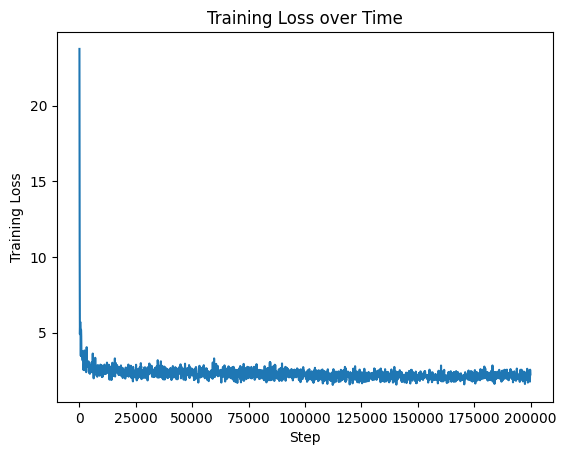

In [46]:
import matplotlib.pyplot as plt

plt.plot(stepi, lossi)
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time')
plt.show()


In [47]:
def evaluate_test_set(X, Y, parameters):
    C, W1, b1, W2, b2 = parameters
    with torch.no_grad():
        emb = C[X]
        h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y)
    return loss.item()

test_loss = evaluate_test_set(Xte, Yte, parameters)
print(f"Test Loss: {test_loss}")


Test Loss: 2.1581881046295166


In [48]:
def sample_names(num_names, parameters, max_length=10):
    C, W1, b1, W2, b2 = parameters
    names = []
    for _ in range(num_names):
        context = [0] * block_size  # Start with context of zeros
        name = ''
        while True:
            emb = C[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            char = itos[ix]
            if char == '.':
                break
            name += char
            context = context[1:] + [ix]
            if len(name) >= max_length:
                break
        names.append(name)
    return names

generated_names = sample_names(10, parameters)
print("Generated Names:")
for name in generated_names:
    print(name.capitalize())


Generated Names:
Fran
Izaan
Dau
Eianne
Tilvin
Geus
Torahlona
Brodisa
Kateymani
Jore
